# Benchmarking Super Earth CMF Functions

*Kieron Brandt 2026*

In [2]:
%load_ext autoreload
%autoreload all

import numpy as np
import matplotlib.pyplot as plt
import time
from cmf_utility import f_cmf, Abundance_to_CMF, Fast_Abundance_CMF

plt.rcParams['font.size'] = 12

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Benchmark f_cmf()

In [18]:
NUM = int(1e5)

mass = np.random.rand(NUM) * 12
radius = (np.random.rand(NUM)+0.5) * 2.5

start = time.time()
f_cmf(mass, radius)
runtime = time.time() - start
print("{:.5f} s for {} [VECTORIZED]".format(runtime, NUM))
print("{:.5f} ms iterations [VECTORIZED]".format(1e3 * runtime/NUM))


start = time.time()
for i in range(NUM):
    f_cmf(mass[i], radius[i])
runtime = time.time() - start

print("{:.5f} s for {} [LOOP]".format(runtime, NUM))
print("{:.5f} ms iterations [LOOP]".format(1e3 * runtime/NUM))

0.04893 s for 100000 [VECTORIZED]
0.00049 ms iterations [VECTORIZED]
4.74762 s for 100000 [LOOP]
0.04748 ms iterations [LOOP]


Verdict: Vectorized f_cmf is lightning-fast, no need to precompute grid

## Benchmark Abundance_to_CMF()

In [4]:
NUM = int(5e3)

fe = np.random.rand(NUM)-0.5
mg = np.random.rand(NUM)-0.5

start = time.time()
Abundance_to_CMF(fe, mg)
runtime = time.time() - start
print("{:.5f} s for {} [VECTORIZED]".format(runtime, NUM))
print("{:.5f} ms iterations [VECTORIZED]".format(1e3 * runtime/NUM))


start = time.time()
for i in range(NUM):
    Abundance_to_CMF(fe[i], mg[i])
runtime = time.time() - start

print("{:.5f} s for {} [LOOP]".format(runtime, NUM))
print("{:.5f} ms iterations [LOOP]".format(1e3 * runtime/NUM))

49.73405 s for 5000 [VECTORIZED]
9.94681 ms iterations [VECTORIZED]
48.71482 s for 5000 [LOOP]
9.74296 ms iterations [LOOP]


Verdict: Not terrible, weird that looping is better. For 10 million this would take ~8 hours, so probably best to precompute over the abundances

## Precompute Grid

NOTE: Abundance_to_CMF actually only depends on the difference between [Fe/H] and [X/H] (since logarithms), so it is really a 1D function!

In [5]:
METHOD="Fe2Si"

fespace = np.linspace(-0.5, 0.5, num=201)
xspace = np.linspace(-0.5, 0.5, num=201)

diff = []
cmf = []

for row in range(len(fespace)):
    for col in range(len(xspace)):
        diff.append(fespace[row] - xspace[col])
        cmf.append(Abundance_to_CMF(fespace[row], xspace[col], method=METHOD)[1][0])

In [6]:
diff = np.round(diff, 12)
dset = sorted(set(diff))
diffdiff = []

for d in dset:
    masked = np.asarray(cmf)[diff == d]
    diffdiff.append(max(masked) - min(masked))
    print("{:6} Fe-X Largest Diff : {}".format(d, max(masked) - min(masked)))
    
print("Total Largest Diff: {} (For Fe-Mg {})".format(max(diffdiff), diff[np.argmax(diffdiff)]))

  -1.0 Fe-X Largest Diff : 0.0
-0.995 Fe-X Largest Diff : 1.186550857568136e-15
 -0.99 Fe-X Largest Diff : 6.245004513516506e-17
-0.985 Fe-X Largest Diff : 1.0658141036401503e-14
 -0.98 Fe-X Largest Diff : 6.2103100439969694e-15
-0.975 Fe-X Largest Diff : 3.864963904476326e-15
 -0.97 Fe-X Largest Diff : 2.023728407074543e-14
-0.965 Fe-X Largest Diff : 1.519617764955683e-14
 -0.96 Fe-X Largest Diff : 6.696032617270475e-15
-0.955 Fe-X Largest Diff : 9.414344304126132e-15
 -0.95 Fe-X Largest Diff : 1.7237947180781532e-14
-0.945 Fe-X Largest Diff : 1.3683498778505054e-14
 -0.94 Fe-X Largest Diff : 2.482909711165604e-14
-0.935 Fe-X Largest Diff : 1.321338871651534e-14
 -0.93 Fe-X Largest Diff : 2.4672971998818127e-14
-0.925 Fe-X Largest Diff : 1.5508427875232655e-14
 -0.92 Fe-X Largest Diff : 1.6175429051745738e-14
-0.915 Fe-X Largest Diff : 2.675203808477633e-14
 -0.91 Fe-X Largest Diff : 1.3372983276305206e-14
-0.905 Fe-X Largest Diff : 1.332180893376389e-14
  -0.9 Fe-X Largest Diff : 2.3

Even 1e-7 (weird machine precision stuff?) is way better than the uncertainty on CMF we'll get

In [7]:
diffspace = np.linspace(-1,1,num=1001)
computed = np.zeros(len(diffspace))

for i in range(len(diffspace)):
    computed[i] = Abundance_to_CMF(diffspace[i], 0, method=METHOD)[1][0]

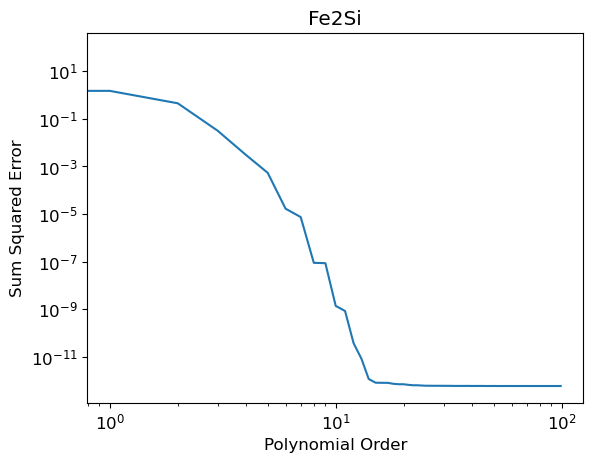

In [8]:
sse = []
coeffs = []

for ord in range(100):
    A = np.zeros([len(computed), ord+1])

    for i in range(len(A[0])):
        A[:, i] = diffspace**i

    m = np.linalg.lstsq(A, computed)[0]

    sse.append(np.sum((A@m - computed)**2))
    coeffs.append(m)

plt.title(METHOD)
plt.loglog(sse)
plt.xlabel("Polynomial Order")
plt.ylabel("Sum Squared Error")
plt.show()

Best Order: 34, SSE 5.9935e-13


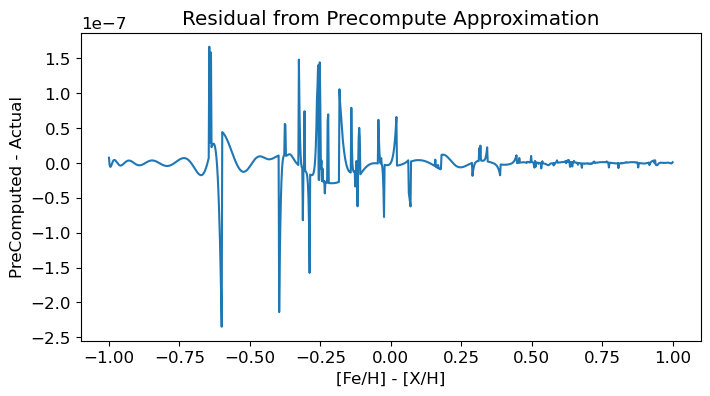

In [25]:
best = 0

for i in range(len(sse)-1):
    if sse[i] < sse[i+1]:
        best = i
        print("Best Order: {}, SSE {:.4e}".format(i, sse[i]))
        break
    
np.savetxt("{}_coeffs.txt".format(METHOD), coeffs[best])

A = np.zeros([len(computed), best+1])

for i in range(len(A[0])):
    A[:, i] = diffspace**i

plt.figure(figsize=(8,4))
plt.title("Residual from Precompute Approximation")
plt.plot(diffspace, A@coeffs[best] - computed)
plt.xlabel("[Fe/H] - [X/H]")
plt.ylabel("PreComputed - Actual")
plt.show()

One last verification across the full parameter space:

In [10]:
fespace = np.linspace(-0.5, 0.5, num=101)
xspace = np.linspace(-0.5, 0.5, num=101)

diffss = []

for fe in fespace:
    for x in xspace:
        diffss.append(Fast_Abundance_CMF(fe, x, method=METHOD) - Abundance_to_CMF(fe, x, method=METHOD)[1][0])
        
print("Maximum Difference from Abundance_to_CMF: {:.5e}".format(max(diffss)))

Maximum Difference from Abundance_to_CMF: 1.18365e-07


## Benchmark Fast_Abundance_CMF()

In [22]:
NUM = int(1e5)

fe = np.random.rand(NUM)-0.5
x = np.random.rand(NUM)-0.5

start = time.time()
Fast_Abundance_CMF(fe, x, method=METHOD)
runtime = time.time() - start
print("{:.5f} s for {} [VECTORIZED]".format(runtime, NUM))
print("{:.5f} ms iterations [VECTORIZED]".format(1e3 * runtime/NUM))


start = time.time()
for i in range(NUM):
    Fast_Abundance_CMF(fe[i], x[i], method=METHOD)
runtime = time.time() - start

print("{:.5f} s for {} [LOOP]".format(runtime, NUM))
print("{:.5f} ms iterations [LOOP]".format(1e3 * runtime/NUM))

0.00700 s for 100000 [VECTORIZED]
0.00007 ms iterations [VECTORIZED]
3.27747 s for 100000 [LOOP]
0.03277 ms iterations [LOOP]


Much better, and vectorized now better than looped as expected!